In [55]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import random
import os
import matplotlib.pyplot as plt

In [56]:
IMAGE_WIDTH = 150
IMAGE_HEIGHT = 150
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS = 3

In [57]:
filenames = os.listdir("./dogs-cats-mini")

In [58]:
categories = []

for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append('dog')
    else:
        categories.append('cat')

In [59]:
df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [60]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [61]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size = 32

In [62]:
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode="nearest",
)

In [63]:
validate_datagen = ImageDataGenerator(rescale=1.0 / 255)

In [64]:
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    "./dogs-cats-mini/",
    x_col="filename",
    y_col="category",
    target_size=IMAGE_SIZE,
    class_mode="binary",
    batch_size=batch_size,
)

Found 20000 validated image filenames belonging to 2 classes.


In [65]:
validation_generator = validate_datagen.flow_from_dataframe(
    validate_df,
    "./dogs-cats-mini/",
    x_col="filename",
    y_col="category",
    target_size=IMAGE_SIZE,
    class_mode="binary",
    batch_size=batch_size,
)

Found 5000 validated image filenames belonging to 2 classes.


loaded VGG16 model + higher level layers

In [66]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

freezing the VGG16 layers

In [67]:
for layer in base_model.layers:
    layer.trainable = False

In [68]:
model = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

In [69]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ ?                      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [70]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

In [71]:
early_stopping = EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True
)

In [72]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=25,
    callbacks=[early_stopping],
)

Epoch 1/25


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


625/625 ━━━━━━━━━━━━━━━━━━━━ 2162s 3s/step - accuracy: 0.6809 - loss: 0.5908 - val_accuracy: 0.7879 - val_loss: 0.4655
Epoch 2/25


2024-06-05 00:38:24.422091: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5000 - val_loss: 0.6368
Epoch 3/25


2024-06-05 00:38:25.273065: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


625/625 ━━━━━━━━━━━━━━━━━━━━ 2095s 3s/step - accuracy: 0.7637 - loss: 0.4829 - val_accuracy: 0.8007 - val_loss: 0.4418
Epoch 4/25


2024-06-05 01:13:20.324112: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.7500 - val_loss: 0.4756
Epoch 5/25


2024-06-05 01:13:20.937601: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


625/625 ━━━━━━━━━━━━━━━━━━━━ 1624s 3s/step - accuracy: 0.7843 - loss: 0.4560 - val_accuracy: 0.7985 - val_loss: 0.4384
Epoch 6/25


2024-06-05 01:40:25.118935: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 833us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.3022
Epoch 7/25


2024-06-05 01:40:25.600415: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


625/625 ━━━━━━━━━━━━━━━━━━━━ 1557s 2s/step - accuracy: 0.7869 - loss: 0.4496 - val_accuracy: 0.7774 - val_loss: 0.4614
Epoch 8/25


2024-06-05 02:06:22.152781: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8750 - val_loss: 0.2282
Epoch 9/25


2024-06-05 02:06:22.738668: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


625/625 ━━━━━━━━━━━━━━━━━━━━ 1538s 2s/step - accuracy: 0.7877 - loss: 0.4436 - val_accuracy: 0.7957 - val_loss: 0.4270
Epoch 10/25


2024-06-05 02:32:00.428457: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 862us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8750 - val_loss: 0.3072
Epoch 11/25


2024-06-05 02:32:00.939278: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


625/625 ━━━━━━━━━━━━━━━━━━━━ 1517s 2s/step - accuracy: 0.7945 - loss: 0.4325 - val_accuracy: 0.7909 - val_loss: 0.4454
Epoch 12/25


2024-06-05 02:57:17.517840: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 823us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.3750 - val_loss: 1.5206
Epoch 13/25


2024-06-05 02:57:18.009991: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


625/625 ━━━━━━━━━━━━━━━━━━━━ 1531s 2s/step - accuracy: 0.7992 - loss: 0.4294 - val_accuracy: 0.8087 - val_loss: 0.4123


In [73]:
model.save("cats_dogs.h5")

In [74]:
import pickle

with open('history.pickle', 'wb') as f:
    pickle.dump(history.history, f)

In [75]:
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f"Validation accuracy: {val_accuracy * 100:.2f}%")

157/157 ━━━━━━━━━━━━━━━━━━━━ 302s 2s/step - accuracy: 0.7776 - loss: 0.4647
Validation accuracy: 77.76%


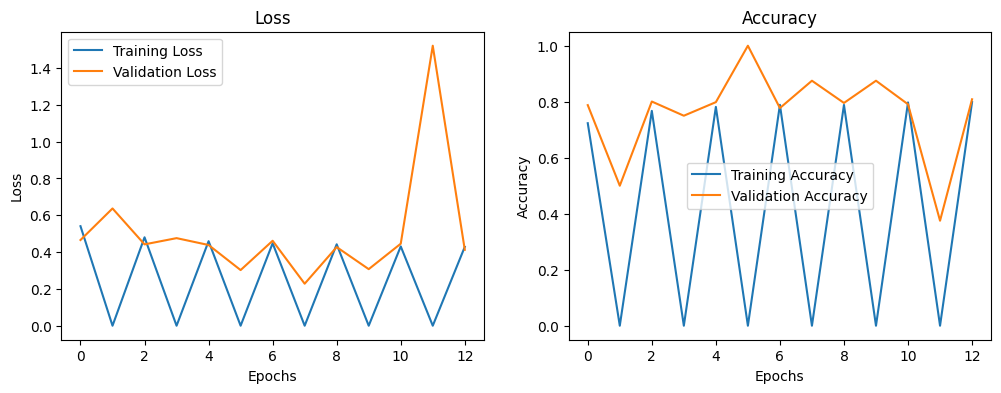

In [76]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.show()